## Spotify Genre Classification using Logistic Regression

This Jupyter notebook will use logistic regression to try and build a model to classify genres on spotify.

## Data Load

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")

## Exploratory Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [ ]:
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [ ]:
df['track_genre'].value_counts()

,count
track_genre,
acoustic,1000
punk-rock,1000
progressive-house,1000
power-pop,1000
pop,1000
...,...
folk,1000
emo,1000
electronic,1000


In [ ]:
"""
import seaborn as sns

# Compute the correlation matrix
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,  # Annotate each cell with its correlation value
    fmt=".2f",   # Format annotations to 2 decimal places
    cmap="coolwarm",  # Color scheme
    cbar=True
)
plt.title("Correlation Matrix of Spotify Features")
plt.show()
"""

'\nimport seaborn as sns\n\n# Compute the correlation matrix\ncorrelation_matrix = df.corr()\n\n# Plot the heatmap\nplt.figure(figsize=(12, 10))\nsns.heatmap(\n    correlation_matrix,\n    annot=True,  # Annotate each cell with its correlation value\n    fmt=".2f",   # Format annotations to 2 decimal places\n    cmap="coolwarm",  # Color scheme\n    cbar=True\n)\nplt.title("Correlation Matrix of Spotify Features")\nplt.show()\n'

## Remove duplicates

The first thing we wanted to focus on after inspecting the structure of the data is removing duplicates. These are songs with the same track_id and track_name, but perhaps different genres. Duplicates can make it harder and more frustrating for the model to perform classification.

In [ ]:
# Shuffle the dataset randomly to avoid any bias from alphabetical order
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Remove duplicates based on 'track_id' and 'track_name', keeping only the first occurrence
df_remove_duplicates = df_shuffled.drop_duplicates(subset=['track_id', 'track_name'], keep='first')

# Print the number of rows before and after removing duplicates
print(f"Original dataframe size: {len(df)}")
print(f"Cleaned dataframe size (duplicates removed): {len(df_remove_duplicates)}")

Original dataframe size: 114000
Cleaned dataframe size (duplicates removed): 89741


We moved about 21% of the rows for duplicates!

In [ ]:
df_remove_duplicates.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,113186,6KwkVtXm8OUp2XffN5k7lY,Hillsong Worship,No Other Name,No Other Name,50,440247,False,0.369,0.598,...,-6.984,1,0.0304,0.00511,0.000000,0.176,0.0466,148.014,4,world-music
1,42819,2dp5I5MJ8bQQHDoFaNRFtX,Internal Rot,Grieving Birth,Failed Organum,11,93933,False,0.171,0.997,...,-3.586,1,0.1180,0.00521,0.801000,0.420,0.0294,122.223,4,grindcore
2,59311,5avw06usmFkFrPjX8NxC40,Zhoobin Askarieh;Ali Sasha,Noise A Noise 20.4-1,"Save the Trees, Pt. 1",0,213578,False,0.173,0.803,...,-10.071,0,0.1440,0.61300,0.001910,0.195,0.0887,75.564,3,iranian
3,91368,75hT0hvlESnDJstem0JgyR,Bryan Adams,All I Want For Christmas Is You,Merry Christmas,0,151387,False,0.683,0.511,...,-5.598,1,0.0279,0.40600,0.000197,0.111,0.5980,109.991,3,rock
4,61000,4bY2oZGA5Br3pTE1Jd1IfY,Nogizaka46,バレッタ TypeD,月の大きさ,57,236293,False,0.555,0.941,...,-3.294,0,0.0481,0.48400,0.000000,0.266,0.8130,92.487,4,j-idol


Features, like 'track_id' and 'track_name' are unique identifiers to the song and do not provide any meaninful information for prediction. Furthermore, features like 'artists' and 'album_name' introduce a large number of high-cardinality features, which will make the model unnecessarily complex.

In [ ]:
# Now, we no longer need these variables
drop_columns = ['Unnamed: 0', 'track_id', 'artists', 'track_name', 'album_name']
df = df_remove_duplicates.drop(columns=drop_columns).reset_index(drop=True)

We also check for missing data.

In [ ]:
# checking for missing values in dataset
print("Missing data: ", df.isnull().sum())

Missing data:  popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


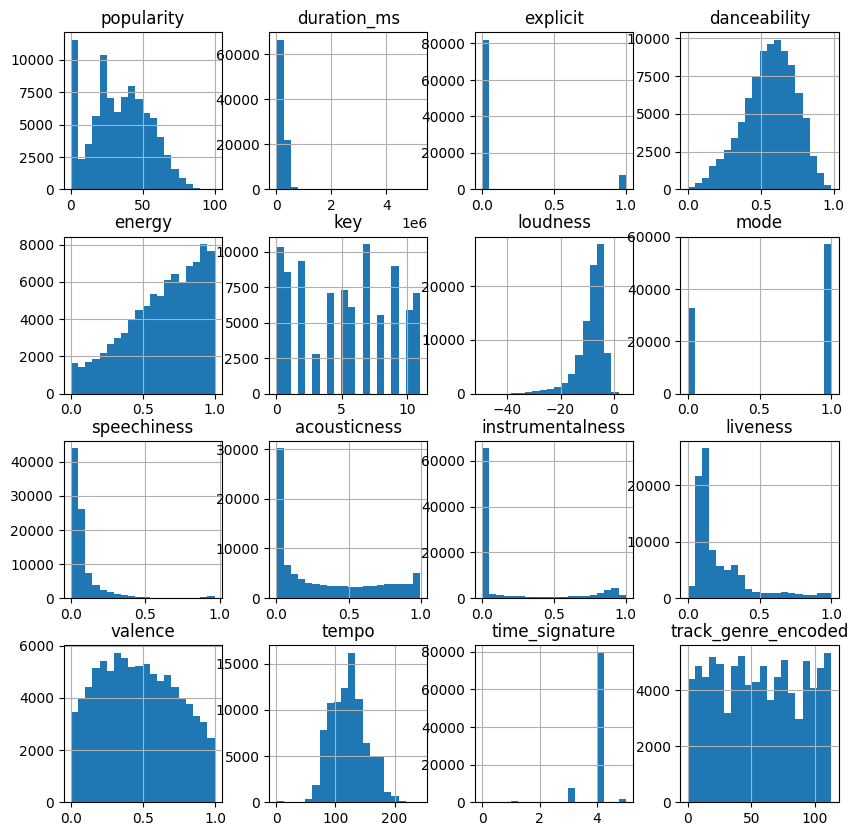

In [ ]:
# Loop through each column in the df and plot a histogram
df.hist(bins=20, figsize=(10, 10))

plt.show()


In [ ]:
df.select_dtypes(exclude='number').head()

,explicit,track_genre
0,False,world-music
1,False,grindcore
2,False,iranian
3,False,rock
4,False,j-idol


In [ ]:
df['explicit'].unique().tolist()

[False, True]

In [ ]:
df['explicit'] = df['explicit'].astype(int)

In [ ]:
df.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,50,440247,0,0.369,0.598,7,-6.984,1,0.0304,0.00511,0.000000,0.176,0.0466,148.014,4,world-music
1,11,93933,0,0.171,0.997,7,-3.586,1,0.1180,0.00521,0.801000,0.420,0.0294,122.223,4,grindcore
2,0,213578,0,0.173,0.803,9,-10.071,0,0.1440,0.61300,0.001910,0.195,0.0887,75.564,3,iranian
3,0,151387,0,0.683,0.511,6,-5.598,1,0.0279,0.40600,0.000197,0.111,0.5980,109.991,3,rock
4,57,236293,0,0.555,0.941,9,-3.294,0,0.0481,0.48400,0.000000,0.266,0.8130,92.487,4,j-idol


In [ ]:
# check for imbalances
print(df['track_genre'].value_counts())

track_genre
tango                999
study                998
sleep                997
idm                  995
comedy               994
                    ... 
edm                  412
singer-songwriter    388
songwriter           386
reggae               374
reggaeton            362
Name: count, Length: 114, dtype: int64


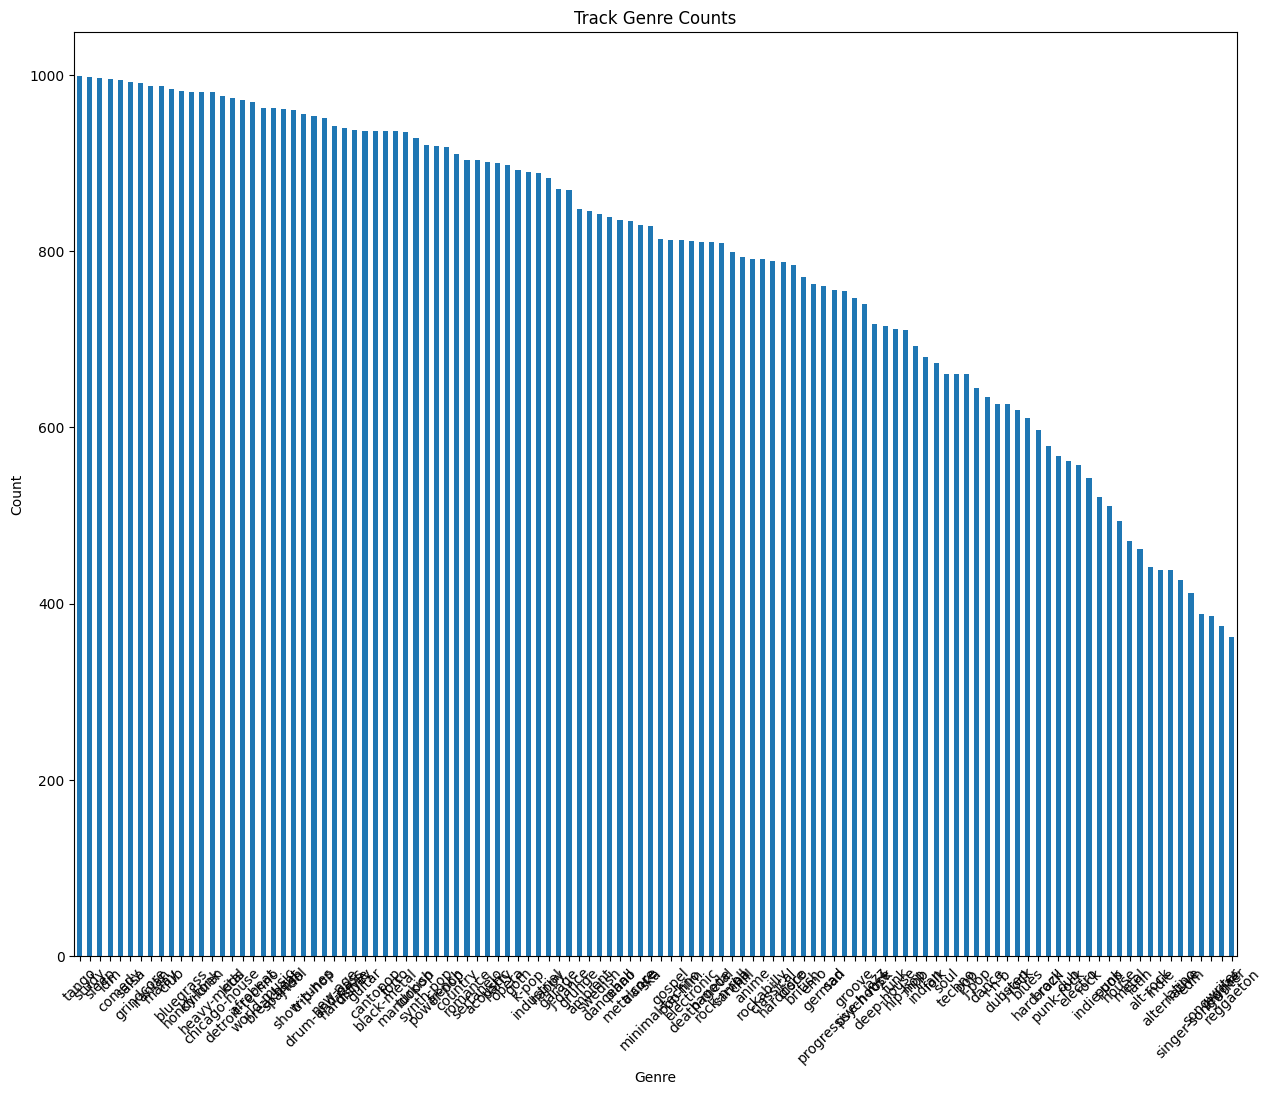

In [ ]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'track_genre' is a column
genre_counts = df['track_genre'].value_counts()

# Plotting the bar plot
plt.figure(figsize=(15,12))
genre_counts.plot(kind='bar')
plt.title('Track Genre Counts')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

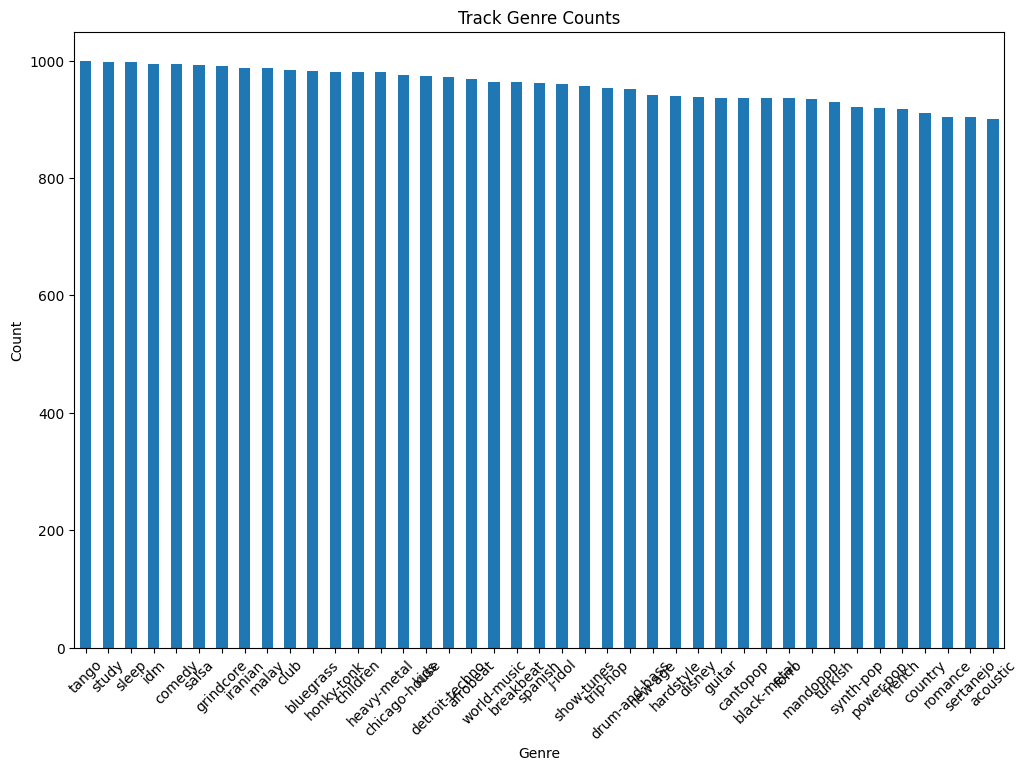

In [ ]:
import matplotlib.pyplot as plt

genre_counts = df['track_genre'].value_counts()

filtered_genres = genre_counts[genre_counts > 900]

# Plotting the bar plot
plt.figure(figsize=(12,8))
filtered_genres.plot(kind='bar')
plt.title('Track Genre Counts')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,50,440247,0,0.369,0.59800,7,-6.984,1,0.0304,0.00511,0.000000,0.1760,0.0466,148.014,4,world-music
1,11,93933,0,0.171,0.99700,7,-3.586,1,0.1180,0.00521,0.801000,0.4200,0.0294,122.223,4,grindcore
2,0,213578,0,0.173,0.80300,9,-10.071,0,0.1440,0.61300,0.001910,0.1950,0.0887,75.564,3,iranian
3,0,151387,0,0.683,0.51100,6,-5.598,1,0.0279,0.40600,0.000197,0.1110,0.5980,109.991,3,rock
4,57,236293,0,0.555,0.94100,9,-3.294,0,0.0481,0.48400,0.000000,0.2660,0.8130,92.487,4,j-idol
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89736,11,393160,0,0.733,0.87800,6,-8.960,0,0.0420,0.00355,0.887000,0.0984,0.6650,126.028,4,idm
89737,49,162613,0,0.554,0.00763,4,-30.566,1,0.0502,0.91500,0.000970,0.2210,0.1560,119.502,4,opera
89738,30,240062,0,0.689,0.55400,9,-8.200,1,0.0759,0.09100,0.914000,0.0867,0.1630,148.002,4,trance
89739,44,216841,0,0.421,0.10700,6,-15.191,1,0.0335,0.94800,0.000000,0.0881,0.1180,104.218,4,acoustic


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['track_genre_encoded'] = le.fit_transform(df['track_genre'])

In [ ]:
genre_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(genre_mapping)

{'acoustic': 0, 'afrobeat': 1, 'alt-rock': 2, 'alternative': 3, 'ambient': 4, 'anime': 5, 'black-metal': 6, 'bluegrass': 7, 'blues': 8, 'brazil': 9, 'breakbeat': 10, 'british': 11, 'cantopop': 12, 'chicago-house': 13, 'children': 14, 'chill': 15, 'classical': 16, 'club': 17, 'comedy': 18, 'country': 19, 'dance': 20, 'dancehall': 21, 'death-metal': 22, 'deep-house': 23, 'detroit-techno': 24, 'disco': 25, 'disney': 26, 'drum-and-bass': 27, 'dub': 28, 'dubstep': 29, 'edm': 30, 'electro': 31, 'electronic': 32, 'emo': 33, 'folk': 34, 'forro': 35, 'french': 36, 'funk': 37, 'garage': 38, 'german': 39, 'gospel': 40, 'goth': 41, 'grindcore': 42, 'groove': 43, 'grunge': 44, 'guitar': 45, 'happy': 46, 'hard-rock': 47, 'hardcore': 48, 'hardstyle': 49, 'heavy-metal': 50, 'hip-hop': 51, 'honky-tonk': 52, 'house': 53, 'idm': 54, 'indian': 55, 'indie': 56, 'indie-pop': 57, 'industrial': 58, 'iranian': 59, 'j-dance': 60, 'j-idol': 61, 'j-pop': 62, 'j-rock': 63, 'jazz': 64, 'k-pop': 65, 'kids': 66, 'lat

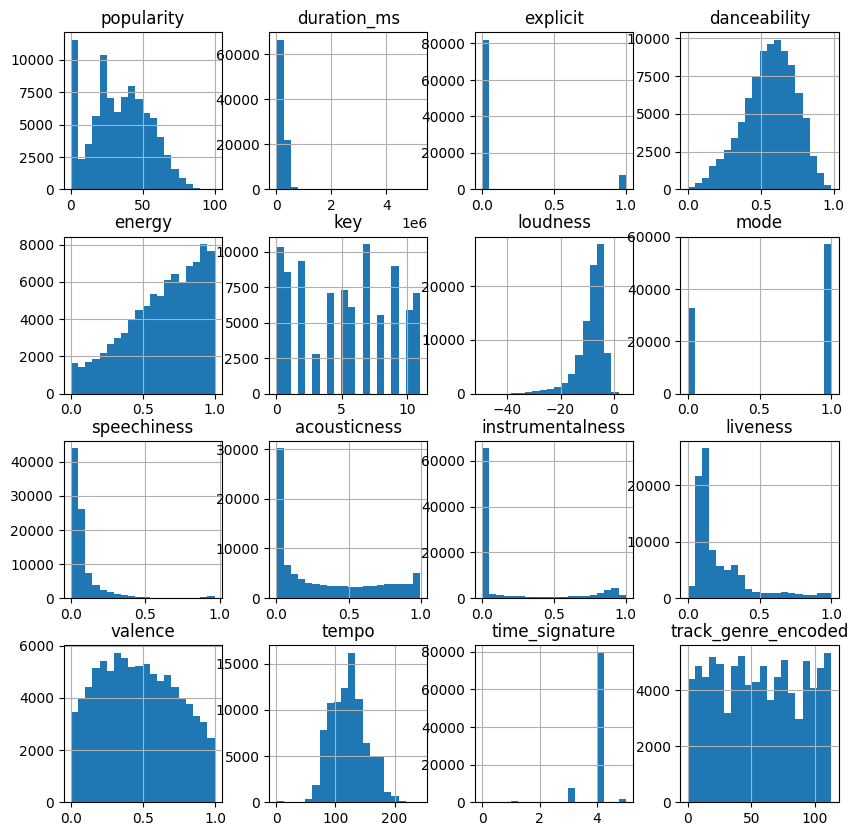

In [30]:
# Loop through each column in the df and plot a histogram
df.hist(bins=20, figsize=(10, 10))

plt.show()